# W266 Authorship Attribution -- Model Builing

## Importing Libraries

In [1]:
!pip install -q transformers
!pip install -q datasets
#!pip install datasets

In [2]:
import numpy as np 
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re

from sklearn.utils import shuffle

from datasets import Dataset
# Use HuggingFace's datasets object
from datasets import load_dataset
from transformers import AutoTokenizer, BertTokenizer, TFBertModel

import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import nltk
nltk.download('popular')
from nltk.tokenize import sent_tokenize, word_tokenize

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

## Load Data
Our dataset was generated using the [Project Gutenberg book API](https://github.com/c-w/Gutenberg) \(Also seen on [PyPl](https://pypi.python.org/pypi/Gutenberg)). 

Our data generation notebook can be found [here](https://colab.research.google.com/drive/1PHUzNh1Giobto7WriB48osfbDFvyvsL4)

---

Set the working directory for this notebook for ease of access to files.

The command line below assumes that the `W266 Term Project` folder is a shortcut in your Google Drive main/homepage (My Drive)

In [5]:
df = pd.read_csv("gdrive/MyDrive/W266 Term Project/data.csv")
df.head(2)

,Unnamed: 0,text,author,etxt_id,title,subject,author_label
0,0,\n\n\n\nTHE TRAGEDY OF ROMEO AND JULIET\n\n\n\...,"Shakespeare, William",1513,Romeo and Juliet,"Youth -- Drama', 'Juliet (Fictitious character...",0
1,1,"\n\n\n\nTHE TRAGEDY OF HAMLET, PRINCE OF DENMA...","Shakespeare, William",1524,"Hamlet, Prince of Denmark","Tragedies', 'Denmark -- Drama', 'Fathers -- De...",0


In [6]:
def paragraphs(text):
  """
  Turn documents into paragraphs using /n/n linebreaks 
  and replacing /n newlines with spaces
  """
  paras = [i for i in text.split("\n\n") if i != ""]
  rm_linebreak = [i.replace('\n', ' ') for i in paras]
  unif_spaces = [re.sub(' +', ' ', i) for i in rm_linebreak]
  return unif_spaces
# Example output of paragraphs (for Pride and Prejudice)
txt_sample = paragraphs(df['text'][10])
txt_sample[100:110]

[' Mr. Bennet was so odd a mixture of quick parts, sarcastic humour, reserve, and caprice, that the experience of three-and-twenty years had been insufficient to make his wife understand his character. _Her_ mind was less difficult to develop. She was a woman of mean understanding, little information, and uncertain temper. When she was discontented, she fancied herself nervous. The business of her life was to get her daughters married; its solace was visiting and news.',
 ' Chapter 2',
 ' Mr. Bennet was among the earliest of those who waited on Mr. Bingley. He had always intended to visit him, though to the last always assuring his wife that he should not go; and till the evening after the visit was paid she had no knowledge of it. It was then disclosed in the following manner. Observing his second daughter employed in trimming a hat, he suddenly addressed her with,',
 ' “I hope Mr. Bingley will like it, Lizzy.”',
 ' “We are not in a way to know _what_ Mr. Bingley likes,” said her moth

- [Remove unwanted spaces from string with regex](https://www.geeksforgeeks.org/python-remove-unwanted-spaces-from-string/)
- [NLTK tokenize](https://www.nltk.org/api/nltk.tokenize.html)

## EDA

KeyError: ignored

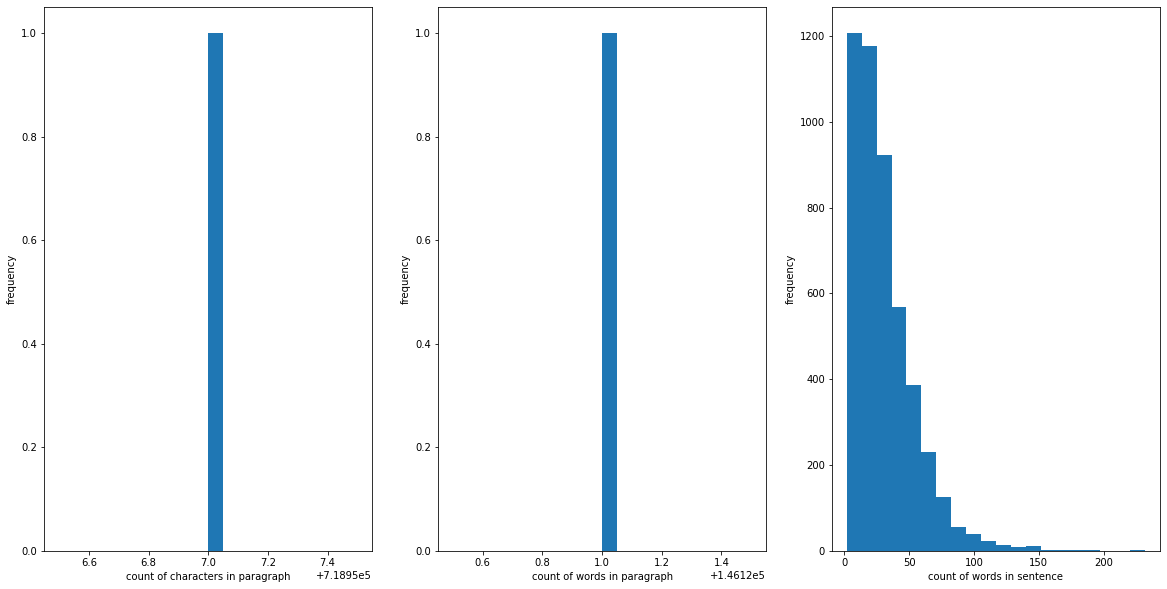

In [ ]:
# Get the number of characters in txt_sample (from "Load Data" section above)
chars_in_parag = [len(i) for i in txt_sample]
# Get number of words in each paragraph of txt_sample
#      Tokenize txt_sample by word from each sentence
words_in_parag = [len(j) for j in [word_tokenize(i) for i in txt_sample]]
# Get number of words in each sentence of each paragraph of txt_sample
#      Get words in each sentence
words_in_sent = [[word_tokenize(j) for j in sent_tokenize(i)] for i in txt_sample]
#      Count words in words_in_sent
word_in_sent_cts = [num for sublist in [[len(j) for j in i] for i in words_in_sent] for num in sublist]

# Visualize character and word count distribution
n_bins = 20

fig, axs = plt.subplots(1, 3, sharey=False, tight_layout=False, figsize = (20, 10))
axs[0].hist(chars_in_parag, bins=n_bins)
axs[0].set_xlabel("count of characters in paragraph")
axs[0].set_ylabel("frequency")
axs[1].hist(words_in_parag, bins=n_bins)
axs[1].set_xlabel("count of words in paragraph")
axs[1].set_ylabel("frequency")
axs[2].hist(word_in_sent_cts, bins=n_bins)
axs[2].set_xlabel("count of words in sentence")
axs[2].set_ylabel("frequency")
title = "Text count distributions for " + df['title'][10]
plt.suptitle(title);

In [ ]:
# Get the middle 50% of sentence lengths in Pride and Prejudice
result = [np.percentile(word_in_sent_cts, 25), np.percentile(word_in_sent_cts, 75)]
print(f"The average 50% of sentences in Pride and Prejudice are between {result[0]} and {result[1]} words long")

The average 50% of sentences in Pride and Prejudice are between 13.0 and 41.0 words long


## Data Preprocessing
- Shuffle
- Select relevant columns ('text', 'author_label')
- Load author key, value pairs dictionary

In [7]:
df = df.loc[:, ['text', 'author_label', 'title']]
df['paragraph'] = df['text'].apply(paragraphs)
df_paragraph = df.explode('paragraph')[['paragraph', 'author_label', 'title']]
df_paragraph = df_paragraph.reset_index()
df_paragraph.iloc[30:36,]

,index,paragraph,author_label,title
30,0,SAMPSON. A dog of that house shall move me to ...,0,Romeo and Juliet
31,0,"GREGORY. That shows thee a weak slave, for the...",0,Romeo and Juliet
32,0,"SAMPSON. True, and therefore women, being the ...",0,Romeo and Juliet
33,0,GREGORY. The quarrel is between our masters an...,0,Romeo and Juliet
34,0,"SAMPSON. ’Tis all one, I will show myself a ty...",0,Romeo and Juliet
35,0,GREGORY. The heads of the maids?,0,Romeo and Juliet


In [8]:
text_df = pd.DataFrame()

for title in df_paragraph.title.unique():
  text = df_paragraph.loc[df_paragraph['title'] == title, :]
  text["paragraph_lens"] = [len(word_tokenize(i)) for i in text['paragraph']]
  p_25 = np.percentile(text["paragraph_lens"], 25)
  p_75 = np.percentile(text["paragraph_lens"], 75)
  selection = text.loc[(text["paragraph_lens"] >= p_25) & (text["paragraph_lens"] <= p_75), :]
  text_df = pd.concat([text_df, selection])
  del selection

text_df = shuffle(text_df, random_state=42)
print(len(text_df))
text_df.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


140182


,index,paragraph,author_label,title,paragraph_lens
248303,179,"“But I have,” she gasped. “I have the money. I...",18,The Secret Agent: A Simple Tale,29
176581,99,ATHENIAN: That is a very fair question. In the...,10,Laws,17


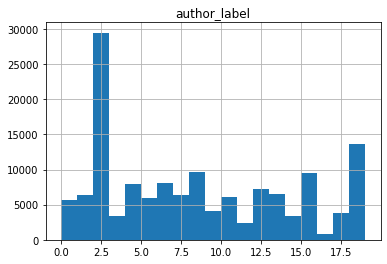

In [ ]:
text_df.hist('author_label', bins=np.arange(0, 20));
print(len(text_df[text_df['author_label'] == 2])/len(text_df))

In [9]:
author_vals = pickle.load(open("gdrive/MyDrive/W266 Term Project/id2auth.pkl", 'rb'))
author_vals

{0: 'Shakespeare, William',
 1: 'Austen, Jane',
 2: 'Dickens, Charles',
 3: 'Thoreau, Henry David',
 4: 'Sinclair, Upton',
 5: 'Fitzgerald, F. Scott (Francis Scott)',
 6: 'Doyle, Arthur Conan',
 7: 'Barrie, J. M. (James Matthew)',
 8: 'Twain, Mark',
 9: 'Shelley, Mary Wollstonecraft',
 10: 'Plato',
 11: 'Poe, Edgar Allan',
 12: 'Baum, L. Frank (Lyman Frank)',
 13: 'Du Bois, W. E. B. (William Edward Burghardt)',
 14: 'Chesterton, G. K. (Gilbert Keith)',
 15: 'Montgomery, L. M. (Lucy Maud)',
 16: 'Tapper, Thomas',
 17: 'Hawthorne, Nathaniel',
 18: 'Conrad, Joseph',
 19: 'Christie, Agatha'}

## Keras Model -- With paragraph level text

Starting code from [HuggingFaceThreeWays_3_Keras.ipynb](https://github.com/datasci-w266/2021-fall-main/blob/master/materials/walkthrough_notebooks/bert_as_black_box/HuggingFaceThreeWays_3_Keras.ipynb)

In [10]:
dataset = Dataset.from_pandas(text_df)
dataset = dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['index', 'paragraph', 'author_label', 'title', 'paragraph_lens', '__index_level_0__'],
        num_rows: 112145
    })
    test: Dataset({
        features: ['index', 'paragraph', 'author_label', 'title', 'paragraph_lens', '__index_level_0__'],
        num_rows: 28037
    })
})

In [ ]:
set(dataset['train']['author_label'])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

In [ ]:
set(dataset['test']['author_label'])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

In [11]:
# Tokenizer Selection
TRAIN_SIZE = len(dataset['train'])
TEST_SIZE = len(dataset['test'])

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["paragraph"], padding="max_length", truncation=True)

tokenized_datasets =  dataset.map(tokenize_function, batched=True)

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(TRAIN_SIZE))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(TEST_SIZE))
full_train_dataset = tokenized_datasets["train"]
full_eval_dataset = tokenized_datasets["test"]

  0%|          | 0/113 [00:00<?, ?ba/s]

  0%|          | 0/29 [00:00<?, ?ba/s]

In [12]:
LABEL_COUNT = len(df['author_label'].unique())

model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=LABEL_COUNT)

# Encode Data
tf_train_dataset = small_train_dataset.remove_columns(["paragraph"]).with_format("tensorflow")
tf_eval_dataset = small_eval_dataset.remove_columns(["paragraph"]).with_format("tensorflow")

train_features = {x: tf_train_dataset[x] for x in tokenizer.model_input_names}
train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_features, tf_train_dataset["author_label"]))
train_tf_dataset = train_tf_dataset.shuffle(len(tf_train_dataset)).batch(8)

eval_features = {x: tf_eval_dataset[x] for x in tokenizer.model_input_names}
eval_tf_dataset = tf.data.Dataset.from_tensor_slices((eval_features, tf_eval_dataset["author_label"]))
eval_tf_dataset = eval_tf_dataset.batch(8)


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Finetuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

model.summary()

model.fit(train_tf_dataset, validation_data=eval_tf_dataset, epochs=3)

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  15380     
                                                                 
Total params: 108,325,652
Trainable params: 108,325,652
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3


ResourceExhaustedError: ignored

Would be cool to have: get the softmax of the logits.

In [ ]:
# Model Export Code
# trainer.save_model("path/to/awesome-name-you-picked")
# tokenizer.save_pretrained("path/to/repo/clone/your-model-name")

# tokenizer = AutoTokenizer.from_pretrained("namespace/awesome-name-you-picked")
# model = TFAutoModel.from_pretrained("namespace/awesome-name-you-picked")

## BERT Model Fine-tuning
From the [BERT Fine-tuning notebook](https://github.com/datasci-w266/2022-spring-main/blob/master/materials/walkthrough_notebooks/bert-finetuning/BERT_Fine-tuning.ipynb)

Following the example code in the following [documentation](https://huggingface.co/transformers/v3.0.2/model_doc/bert.html#transformers.BertModel)

In [14]:
#train_examples_batch, train_labels_batch = next(iter(train_data.batch(20000)))
#test_examples_batch, test_labels_batch = next(iter(test_data.batch(5000)))
#train_examples_batch

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
bert_model = TFBertModel.from_pretrained('bert-base-cased')


#x_text = bert_tokenizer([txt for txt in df['text']])
#y_labels = df['author_label']

num_train_examples = 156
num_test_examples = 39
#num_tiny_set = 5

max_length = 80

x_train = bert_tokenizer([txt for txt in df['text'][:num_train_examples]], 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_train = df['author_label'][:num_train_examples]

df_test = df.iloc[156:, ]

x_test = bert_tokenizer([txt for txt in df_test['text'][:num_test_examples]], 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_test = df_test['author_label'][:num_test_examples]


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
"""def bert_tokenize_function(examples):
    return bert_tokenizer(examples, padding="max_length", truncation=True)
df_bert = pd.DataFrame.from_dict(data = {"text": df['text'].apply(bert_tokenize_function),
                                         "author_label": df['author_label']})
dataset_bert = Dataset.from_pandas(df_bert)
dataset_bert = dataset_bert.train_test_split(test_size=0.2)
dataset_bert"""

In [ ]:
"""#bert_tokenized_datasets =  dataset.map(bert_tokenize_function, batched=True)

bert_small_train_dataset = dataset_bert["train"].shuffle(seed=42).select(range(156))
bert_small_eval_dataset = dataset_bert["test"].shuffle(seed=42).select(range(39))
bert_full_train_dataset = dataset_bert["train"]
bert_full_eval_dataset = dataset_bert["test"]"""

In [15]:
def create_classification_model(hidden_size = 200, 
                                train_layers = -1, 
                                optimizer=tf.keras.optimizers.Adam()):
    """
    Build a simple classification model with BERT. Let's keep it simple and don't add dropout, layer norms, etc.
    """

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                  'token_type_ids': token_type_ids,
                  'attention_mask': attention_mask}


    #restrict training to the train_layers outer transformer layers
    if not train_layers == -1:

            retrain_layers = []

            for retrain_layer_number in range(train_layers):

                layer_code = '_' + str(11 - retrain_layer_number)
                retrain_layers.append(layer_code)

            for w in bert_model.weights:
                if not any([x in w.name for x in retrain_layers]):
                    w._trainable = False


    bert_out = bert_model(bert_inputs)


    classification_token = tf.keras.layers.Lambda(lambda x: x[:,0,:], name='get_first_vector')(bert_out[0])


    hidden = tf.keras.layers.Dense(hidden_size, name='hidden_layer')(classification_token)

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], 
                                          outputs=[classification])
    
    classification_model.compile(optimizer=optimizer,
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                            metrics='accuracy')


    return classification_model

In [16]:
classification_model = create_classification_model()     
classification_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
                         y_train,
                         validation_data=([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask],
                         y_test),
                        epochs=5)
                        #batch_size=8)

classification_model.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], 
                             #batch_size=8, 
                             steps=2)

#classification_model([x.input_ids, x.token_type_ids, x.attention_mask]

Epoch 1/5
5/5 [==============================] - 32s 2s/step - loss: -109.6352 - accuracy: 0.0513 - val_loss: -977.0023 - val_accuracy: 0.0000e+00
Epoch 2/5
5/5 [==============================] - 7s 1s/step - loss: -498.4492 - accuracy: 0.0577 - val_loss: -1788.6097 - val_accuracy: 0.0000e+00
Epoch 3/5
5/5 [==============================] - 7s 1s/step - loss: -828.8810 - accuracy: 0.0577 - val_loss: -2781.1150 - val_accuracy: 0.0000e+00
Epoch 4/5
5/5 [==============================] - 7s 1s/step - loss: -1246.8141 - accuracy: 0.0577 - val_loss: -3978.7676 - val_accuracy: 0.0000e+00
Epoch 5/5
5/5 [==============================] - 7s 1s/step - loss: -958.9581 - accuracy: 0.0577 - val_loss: 2899.7617 - val_accuracy: 0.0000e+00


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

This code is separate from the BERT_Fine_tuning code above. It's just from 
```
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
bert_model = TFBertModel.from_pretrained('bert-base-cased')
```

In [17]:
bert_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

bert_model.summary()

bert_model.fit(train_tf_dataset, validation_data=eval_tf_dataset, epochs=3)

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3


ResourceExhaustedError: ignored